## Workbook 4: Multivariate Linear Regressions

All resources, unless otherwise specified, are created by Nikhil Chinchalkar

There's one last topic in our baseline for Python, which is linear regressions. This is undoubtedly the most technical aspect of NME, but is also one of the most important, since a lot of data science comes down to modelling patterns. While most of the code that we'll write here is pretty simple, the main difficulty comes with understanding what exactly is going on behind the scenes. Anyone can run a regression, but to understand and interpret your results is another thing.

Unfortunately, since there's a lot to learn here, there's not going to be too much to interact with on your own, so this is more like a reading assignment, but you can always fiddle with the things I have in place.

Let's just import libraries to start. The new one here is `statsmodels`.

In [7]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

If the above gives you an error, try running the code below (uncommenting it):

In [5]:
%pip install statsmodels
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
  Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-macosx_12_0_arm64.whl (11.1 MB)
Note: you may need to restart the kernel to use updated packages.


We'll now get started on making a model. Here, I'm going to try and predict the life expectancy of a country, given it's population, the year, GDP per capita, and what continent it resides in (Africa, Americas, Asia, Europe Oceania). These will be the inputs of our model, and it's important that we pre-register them here.

To do that, we'll first need to import our data, and drop any NaNs, since it'll mess up our modelling. The data comes from [here](https://github.com/kirenz/datasets/blob/master/gapminder.csv).

In [8]:
data = pd.read_csv('gapminder.csv').dropna()

data.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


This data is already pretty cleaned, but to model it we need to do one more thing. We already specified that we wanted to include which continent that a country resides in, but in the column `continent`, we're seeing string values. This is a problem, since the model can't interpret strings - only floats. To convert these strings into floats, we can make them 'dummy variables'. This just means that we make a new column for each value in the `continent` column, and make the corresponding column either 1 or 0 depending on if the column matches up with the continent. It's easier to explain when you see it done:

In [9]:
continent = pd.get_dummies(data['continent'], drop_first=True).astype(int)
data = pd.concat([data,continent], axis=1)
data.head()

,country,continent,year,lifeExp,pop,gdpPercap,Americas,Asia,Europe,Oceania
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,0,1,0,0
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,0,1,0,0
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,0,1,0,0
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,0,1,0,0
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,0,1,0,0


The above uses the Pandas and the `get_dummies` function to make dummy variables out of the specified column, converts it to an integer (default is a boolean [T/F], which won't work) and then concatenates it back to the original dataset, horizontally. Now, you can get a better sense of what's going on, with the last 4 columns being indicator variables for the `continent` column. 

You might notice that Africa isn't included as a column. This is because we included the `drop_first` parameter to the `get_dummies` function, which 'drops', or removes, the first dummy column. The reason this is OK (and actually preferred) is because we can derive that column from the others. That is, when Africa is 1, that's the same as `Americas`, `Asia`, `Europe`, and `Oceania` being 0. So, there's no need to include it. In fact, if we did include it, it would lead to *collinearity*, which is when multiple inputs to a model are highly correlated (since `Africa` would be directly correlated with the other 4 columns). This is a problem, since it means we're undermining the strength of our inputs, since the model would split the effect of the two correlated inputs across them. 

This is also better explained with an example. Let's say we had a column for GDP too, and we included that as an input. This would be very highly correlated with both population and GDP per capita, since GDP is the same as population times GDP per capita. Then, if we inputted GDP into the model as well, the effect that GDP per capita had on life expectancy, say, would be split across both GDP and GDP per capita, weakening the model. Long story short, we don't want very highly correlated inputs.

So, let's check to see if we have any right now:

In [12]:
inputs = ['pop','gdpPercap','year','Americas','Asia','Europe','Oceania']
data[inputs].corr()

,pop,gdpPercap,year,Americas,Asia,Europe,Oceania
pop,1.000000,-0.025600,8.230808e-02,-2.219817e-02,2.459466e-01,-6.062454e-02,-2.334280e-02
gdpPercap,-0.025600,1.000000,2.273181e-01,-3.715837e-03,3.834877e-02,3.809787e-01,1.383432e-01
year,0.082308,0.227318,1.000000e+00,-1.574294e-15,2.402565e-15,2.118443e-15,-6.039044e-15
Americas,-0.022198,-0.003716,-1.574294e-15,1.000000e+00,-2.543436e-01,-2.392372e-01,-5.524946e-02
Asia,0.245947,0.038349,2.402565e-15,-2.543436e-01,1.000000e+00,-2.847707e-01,-6.576498e-02
Europe,-0.060625,0.380979,2.118443e-15,-2.392372e-01,-2.847707e-01,1.000000e+00,-6.185896e-02
Oceania,-0.023343,0.138343,-6.039044e-15,-5.524946e-02,-6.576498e-02,-6.185896e-02,1.000000e+00


It's a bit hard to see since there's a lot of correlation values in this matrix, but the highest correlation between any two distinct inputs is `Europe` and `gdpPercap`, which is still at a pretty low (.38). So, nothing to worry about collinearity wise (you might worry when there is a correlation greater than 0.8 or so). We can now get started fitting our model.

Before we fit, we need to split up the data into two parts: train and test. This is standard in machine learning, since it allows us to generalize our findings. If we trained our model on the full dataset then we wouldn't be able to confidently say our model generalizes well to 'out-of-sample' data - or data that we haven't seen. That's because we've only seen the model work on data it *has* seen. 

So, to get around this, we split the data to artificially generate 'out-of-sample' data, that the model won't see until after it's done training. The typical split for train/test is 70/30, meaning 70% of the data goes to the train set, and 30% of the data goes to the test set. Since this is done randomly, we need to set a 'seed' or a 'state' which allows us to repeatedly run the split and get the same random results every time.

In [13]:
train, test = train_test_split(data, test_size=0.3, random_state=2024) 

Now, we can finally train a model to predict values:

In [14]:
model = sm.OLS(train['lifeExp'],train[inputs]).fit()

Just to get an idea of what this is doing, Python is finding a linear model that can best predict `lifeExp` based on the given `inputs`. We can just visually see how well it does this with the following plot, which shows our predicted values (based on the `inputs`) against the actual values:

Text(0, 0.5, 'Actual')

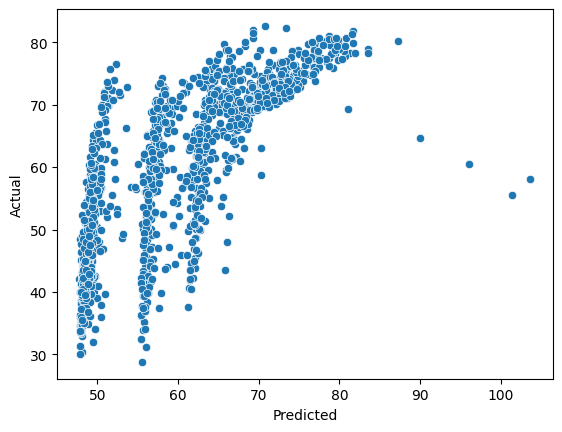

In [16]:
sns.scatterplot(y=train['lifeExp'],x=model.predict(train[inputs]))
plt.xlabel('Predicted')
plt.ylabel('Actual')

That honestly looks pretty bad, but it shows you what's going on under the hood. Though our model is linear (and really is just an equation for a single line), since there is more than 1 input, we're technically modelling in a multidimensional space, so it's difficult to plot the actual line that is our model. Regardless, we'll come up with an equation for the model at the end, when our model will actually be good.

Before we look at the summary metrics of the model, we need to check residual plots. Residuals are basically plots of the errors our model makes against the values that we predict. That is, we put the predicted values in the X-axis and the error (difference between the predicted value and the actual value) on the Y-axis. We're looking for 'random looking' residual plots like this: 

![alt text](https://online.stat.psu.edu/stat462/sites/onlinecourses.science.psu.edu.stat462/files/04slrmodel/residual_fits_handspan/index.png)

If we don't get random residual plots, that means that there's some pattern or effect that isn't being taken into account as we fit the model (that is, if there's a pattern that we can identify in the residuals, we could have identified it in the initial model).

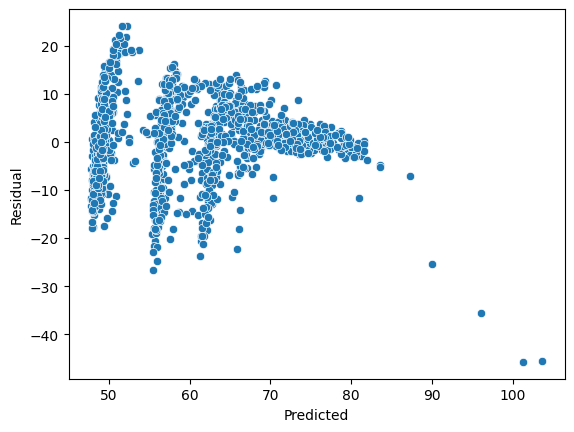

In [17]:
residuals = train['lifeExp'] - model.predict(train[inputs])
sns.scatterplot(x=model.predict(train[inputs]),y=residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

That doesn't look random at all. Since that was the residual plot for the full model, let's try and plot the residuals for each the individual inputs to see which inputs we need to take a closer look at. I'm only going to plot the values that are not discrete, which are `pop` and `gdpPercap`. Also note that I'm changing the X-axis here, since we don't have a predicted value for each of the inputs, only the output. So, we just replace the X-axis with the input instead of a prediction.

<Axes: xlabel='gdpPercap', ylabel='None'>

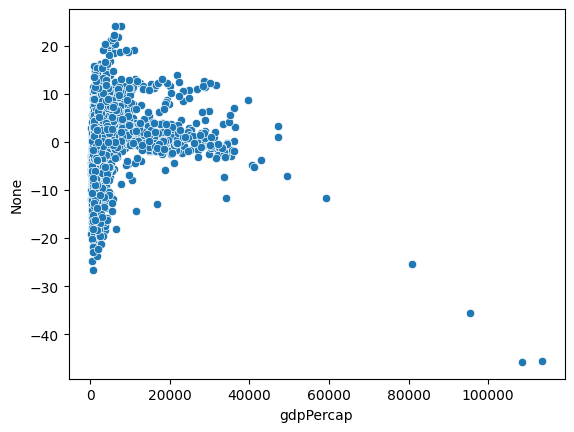

In [18]:
residuals = train['lifeExp'] - model.predict(train[inputs])
sns.scatterplot(x=train['gdpPercap'],y=residuals)

This looks pretty bad - it looks *heteroskedastic*, to be precise. This is a very important term which just means that the residuals do not appear to have equal variances (across the X-axis). That's just one math definition for a way in which the plot does not looking random. The way we solve heteroskedasticity and make the residuals random is by *transforming* the original input (using a log transformation, for instance). 

You should never run a linear regression on heteroskedastic data, since it means your underlying data isn't actually linear (yet). Just to clarify, we can plot out the `gdpPercap` values in our dataset against the `lifeExp` to show how a log transform makes this underlying data linear:

<Axes: xlabel='gdpPercap', ylabel='lifeExp'>

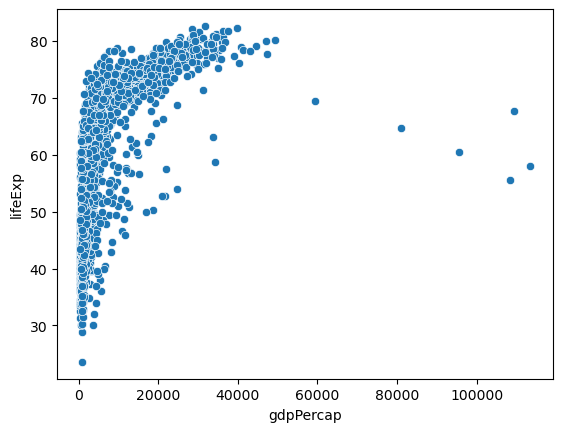

In [278]:
sns.scatterplot(x=data['gdpPercap'],y=data['lifeExp'])

You can kind of see how the above demonstrates non-linear behavior - the data points are stretched out over the X-axis. We can thus take the natural log of the X-axis to make the values not as stretched, and linear, so our model will actually work:

<Axes: xlabel='gdpPercap', ylabel='lifeExp'>

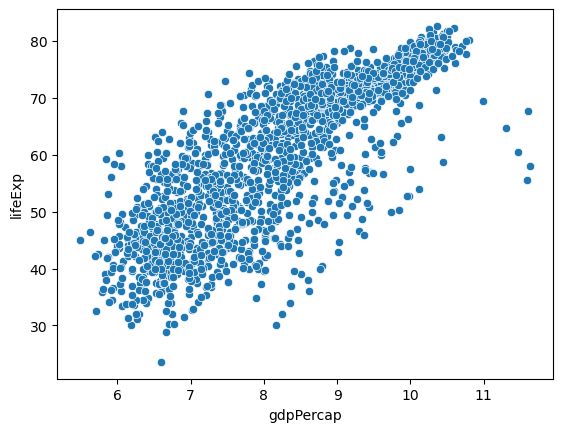

In [279]:
sns.scatterplot(x=np.log(data['gdpPercap']),y=data['lifeExp'])

That looks a lot better. For now, just remember the reasoning for why we did this transformation, and I'll apply it at the end. I'm doing it in this form because `pop` also demonstrates similar heteroskedastic behavior:

<Axes: xlabel='pop', ylabel='None'>

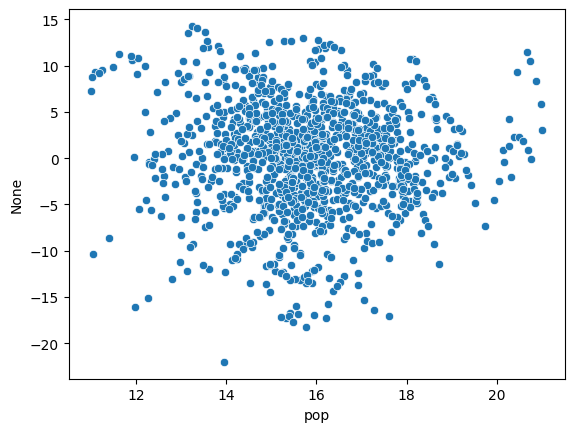

In [22]:
residuals = train['lifeExp'] - model.predict(train[inputs])
sns.scatterplot(x=train['pop'],y=residuals)

This time, you get the idea about what transform we need to make: we need to take the natural log of the `pop` column. Since we want this to take effect on both the train and test sets (otherwise they wouldn't share the same scale), we'll just do it on the original dataset and re-divide the train/test splits. 

Also note that the `data['year'] = data['year'] - 1952` line just means we scale down the year values. Now the `year` column is really the 'years since 1952' column (since 1952 is the lowest year in the dataset). The reason we have to do this is because there's some scaling issues with the `sm.OLS` function - it'll say there's 'numerical problems' if there's a large difference in scale between certain inputs/outputs, so we need to scale down to get rid of that warning. Honestly, there's no difference in not doing this step, but it just clears up any confusion on a reader who might not understand what's going on. Essentially, we need to scale down the values to make them similar, and changing up the `year` column in this format accomplishes that.

In [19]:
data['gdpPercap'] = np.log(data['gdpPercap'])
data['pop'] = np.log(data['pop'])

data['year'] = data['year'] - 1952

train, test = train_test_split(data, test_size=0.3, random_state=2024) 

Now, let's re-train the model and check the residuals, which, if I did this right, should show random-looking residuals:

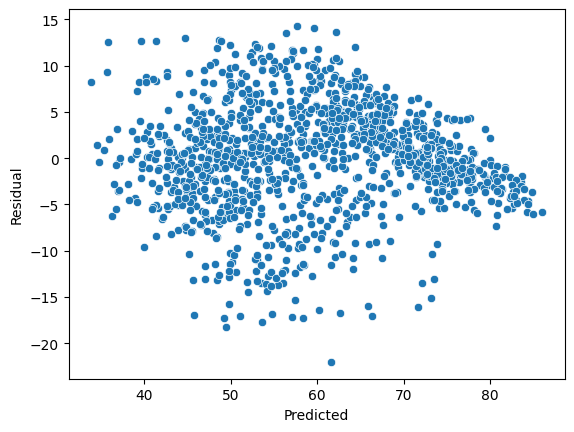

In [20]:
model = sm.OLS(train['lifeExp'],train[inputs]).fit()

residuals = train['lifeExp'] - model.predict(train[inputs])
sns.scatterplot(x=model.predict(train[inputs]),y=residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

Yay! We successfully made a model with random-looking residuals. Now that we've created our model correctly, it's time to put it to the test (literally). I'm going to choose an evaluation metric, which is just a way of telling how good a model is, and evaluate the model's predicted values against the train set's real values as well as the test set's real values.

Keep in mind that we didn't train the model on the test set, so when we get these two evaluation metrics, I'm looking to see if the metrics match up between our train and test sets. If they don't, that means that we're making different errors against the test set than we are against the train set, which means that we're *overfitting* to the train set: our model relies too much on the train set. If they do, that means that we're making the same errors against the train and test sets, which is good - our model does just as well on the train as it does on the test, which means it can generalize to other unseen data as well.

If that didn't really make sense, try this example. Imagine our model is you studying for a test. Let's say there's a practice test and the actual test. If you got 90% of the practice test and 90% on the actual test, that's good - your studying techniques worked well on both the practice and actual. If you got a 90% on the practice and a 50% on the actual, that means your techniques only worked well on the practice - maybe you focused too hard and *overfit* to the practice test style. It's difficult to do well on the practice and even better on the actual, so that might just mean you got lucky and the things you didn't study for didn't appear on the actual test.

Ok, back to actual coding. I'm going to choose MAE (Mean Absolute Error) as the evaluation metric. There's a few more that are standard for non-binary outputs, so I'm just choosing this one arbitrarily. The MAE is just the average of the absolute errors of each point, or on average, how far our prediction deviates from the actual results. You can look up the formula online if it helps.

In [32]:
print(f"MAE Train: {round(mean_absolute_error(y_true=train['lifeExp'],y_pred=model.predict(train[inputs])),5)}")
print(f"MAE Test: {round(mean_absolute_error(y_true=test['lifeExp'],y_pred=model.predict(test[inputs])),5)}")

MAE Train: 4.39804
MAE Test: 4.58237


Since the MAE of the train and test sets are relatively similar, we can conclude that the model generalizes well. If we wanted to interpret the MAE directly, we could say that on average we're about 4 years off the actual life expectancy on a given prediction. That's a pretty good result, given that our dataset has a fairly wide range of life expectancies (ranging rom about 30 to 80).

Let's now peek behind the curtain and see what the actual equation is behind our model, knowing that it generalizes well.

In [24]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                lifeExp   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.907e+04
Date:                Thu, 13 Mar 2025   Prob (F-statistic):                        0.00
Time:                        17:41:56   Log-Likelihood:                         -3768.5
No. Observations:                1192   AIC:                                      7551.
Df Residuals:                    1185   BIC:                                      7587.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

There's a lot of information that was just printed out, but we really only care about a few values. Those are the 'Prob (F-statistic)' at the top right, the 'coef' values for each of our inputs near the left, and the 'P>|t|' values in the middle. Let's unpack these step by step. 

The Prob (F-statistic) value just gives us the probability that our model fits as well as it does given that there is no relationship between any of the inputs and the output. If that probability is lower than a given threshold (which is typically 0.05), then we can reject the idea that there is no relationship between any of the inputs and the output (that is, there is at least some relationship at least one of our inputs and the output: our model is better than the intercept-only one). In our case, since our probability is < 0.05 (0.00), we conclude that our model and its inputs provide a better fit than that of an intercept-only model with none of the inputs. This is good - it means that our model is actually useful.

For the next part, let's jump to the P>|t| values. Technically, when we assign a numeric value to each of the coefficients, we are also evaluating the probability of getting that coefficient. That is, once the coefficient is determined (which is basically a indicator for a non-zero relationship between the input and the output), we evaluate how likely we were to get that value, assuming that there was *no relationship* between that input and output. In other words, for our example for `gdpPercap`, if we assumed that there was 0 relationship between `gdpPercap` and `lifeExp`, what's the likelihood of getting a 5.4 coefficient? That likelihood is the p-value. How these probabilities are calculated and what exactly a simulation of a 0 relationship between the input and output looks like is beyond the scope of this workbook, but that's essentially what we're looking at. Similar to the above, if we find a p-value below the 0.05 threshold, we can reject the idea that there is no relationship between that input and the output (essentially, there is a 5.4 coefficient between `gdpPercap` and `lifeExp`, for example). Since each of our p-values are less than 0.05, we reject each of their 'null' assumptions.

The p-value stuff can get kind of confusing so let me use another example. Let's say we have a coin and we want to assess whether it's fair or not (50% heads 50% tails). If we flip it 10 times and get 10 heads, assuming that the coin is fair, the probability of that happening is $\frac{1}{2}^{10}$, which is very very small (less than 0.05). So, we become skeptical of the fact that the coin is fair and *reject* that idea, opening up the possibility of the coin being biased. That's what's going on when we assess these p-values.

If you wanted to print the p-values with more precision, we could also do this:

In [26]:
#try changing the 0 to a 1 - it's just the index of the 7 coefficients we have
model.pvalues.iloc[1]

np.float64(2.2785930590437503e-218)

Lastly, the coefficients themselves allow us to actually form an equation, which is our model. Remember that we took the natural log of both `pop` and `gdpPercap`, so that's what's included in our equation:

`lifeExp` $ = 0.2229ln($`pop`$) + 5.4148ln($`gdpPercap`$) + 0.2354($`year`$-1952) + 7.9860($`Americas`$)+ 6.1822($`Asia`$) + 11.0897($`Europe`$) + 11.6029($`Oceania`$)$

That giant equation is our model!

We know it generalizes to out-out-sample data too, so let's try to get it to predict the United States' life expectancy in 2012 (it can't go too far into the future since the most recent data point was from 2007). Here's what I'm using as inputs for this calculation:

 * `pop` = 313,900,000
 * `gdpPercap` = 51,784.41
 * `year` = 2012
 * `Americas` = 1
 * `Asia` = 0
 * `Europe` = 0
 * `Oceania` = 0

If I plug these values into the above equation I get 85.25, which isn't too far off from the actual value of 78.74. The equivalent code for this calculation is below:

In [27]:
model.predict([np.log(313900000),np.log(51784.41),2012-1952,1,0,0,0])[0]

np.float64(85.24820485692297)

As promised earlier, here's what our model's predictions *look* like against the actual values. Notice the linear relationship between the predicted and actual values, which is a good sign about the effectiveness of our model:

Text(0, 0.5, 'Actual')

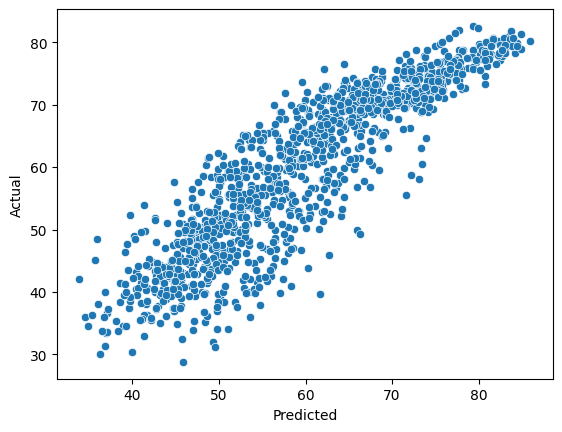

In [28]:
sns.scatterplot(y=train['lifeExp'],x=model.predict(train[inputs]))
plt.xlabel('Predicted')
plt.ylabel('Actual')

That's pretty much it for the basics of linear regression, there's a lot that goes into it for a seemingly simple result. I hope that the math and stats in this section weren't too bad - I tried my best to explain things at a low level. Just to recap, we did the following steps: we got the dataset, we checked for correlations, we split the data up into test/train sets, we initially fit the model and checked for random-looking residuals, then we applied log transforms to the needed columns, after that we refit the model and checked evaluation metrics, then we  interpreted the F-statistics, p-values, and coefficients to make our equation.

That's a lot of work, but eventually it becomes second nature (hopefully). There's a lot of intricacies with this stuff and I'm often Googling to see if I'm doing statistically sound work, so it's very much a constant learning process.

That's it for NME! I hope you enjoyed it as much as I did.